In [14]:
from datasets import load_dataset, Dataset
udata = load_dataset('HuggingFaceH4/ultrachat_200k', split='test_sft')
from typing import Union, List, Tuple
def process_ultrachat_200k_item(
    x: dict,
    is_lat: bool = False,
    single_turn_only: bool = True,
    return_preprocessed: bool = False,
) -> Union[str, dict]:
    assert "messages" in x, f"{x.keys()}"
    assert isinstance(x["messages"], list), f"{type(x['messages']).__mro__}"
    assert all(isinstance(m, dict) for m in x["messages"]), f"{x['messages']}"
    assert all(
        "role" in m and "content" in m for m in x["messages"]
    ), f"{x['messages']}"
    roles_set = set(m["role"] for m in x["messages"])
    assert roles_set == {"user", "assistant"}, f"roles_set={roles_set}"
    assert len(x["messages"]) > 0
    assert x["messages"][0]["role"] == "user"

    # Store the roles and their contiguous segments (i.e. compress all user messages
    # into one larger message)
    role_index_blocks: List[Tuple[str, int, int]] = []
    for i, m in enumerate(x["messages"]):
        if len(role_index_blocks) == 0 or role_index_blocks[-1][0] != m["role"]:
            # Initialize the last block
            role_index_blocks.append((m["role"], i, i))
        else:
            # Extend by one
            role_index_blocks[-1] = (m["role"], role_index_blocks[-1][1], i)
    # Make sure they are including a user request
    assert role_index_blocks[-1][2] == len(x["messages"]) - 1
    assert role_index_blocks[0][1] == 0
    assert len(role_index_blocks) >= 1
    # Make sure they are covering the space
    assert all(
        role_index_blocks[i][2] + 1 == role_index_blocks[i + 1][1]
        for i in range(len(role_index_blocks) - 1)
    )
    # Make sure that all the roles match what is in the prompt
    assert all(
        all(
            x["messages"][i]["role"] == expected_role
            for i in range(start_idx, end_idx + 1)
        )
        for expected_role, start_idx, end_idx in role_index_blocks
    )
    # Make sure that we alternated properly
    assert all(
        role_index_blocks[i][0] != role_index_blocks[i + 1][0]
        for i in range(len(role_index_blocks) - 1)
    )
    if single_turn_only:
        assert role_index_blocks[0][1] == role_index_blocks[0][2]  # start = stop
        if len(role_index_blocks) >= 2:
            assert (
                role_index_blocks[1][1] == role_index_blocks[1][2]
            )  # start = stop
        role_index_blocks = role_index_blocks[:2]  # remove future turns
    else:
        # ehhh... ay lmao
        raise NotImplementedError(
            "Not implemented: only single turn allowable for now"
        )

    user_message = x["messages"][role_index_blocks[0][1]]
    assistant_message = x["messages"][role_index_blocks[1][1]]
    if return_preprocessed:
        raise NotImplementedError("Not implemented")
    else:
        return {
            "question": user_message["content"],
            "answer": assistant_message["content"],
        }
max_udata_len = 1000
udata = udata.filter(lambda x: len(x['messages'][0]['content']) <= 500) # TODO(Adrianoh) please fix thic
udata.shuffle()
data = udata.select(range(max_udata_len))
data = data.map(process_ultrachat_200k_item)

Filter:   0%|          | 0/23110 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [16]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()
from transformers import pipeline, set_seed, Pipeline
# generator = pipeline('text-generation', model='meta-llama/Llama-3.2-1B', device='cuda:3')
generator = pipeline('text-generation', model='meta-llama/Llama-3.2-1B-Instruct', device='cuda:1', torch_dtype=torch.bfloat16)
set_seed(42)
import tqdm
from typing import List
import numpy as np
lengths_input = [len(d['question']) for d in data]
generator.tokenizer.pad_token = generator.tokenizer.eos_token
# generator.tokenizer.pad_token_id = generator.model.config.eos_token_id
def get_output_lengths(
        generator: Pipeline,
        data: Dataset,
        batch_size: int=400,
        max_length: int=1000,
        temperature: float=0.7
    ) -> List[int]:
    lengths_output: list[int] = []
    
    # Process data in batches
    for i in tqdm.tqdm(range(0, len(data), batch_size)):
        batch = data[i:i+batch_size]
        instructions = batch['question']
        assert isinstance(instructions, list) and all(isinstance(i, str) for i in instructions)
        outputs = generator(instructions, max_length=max_length, temperature=temperature, batch_size=batch_size)
        # print(type(outputs), type(outputs[0]), type(outputs[0][0]))
        # print(len(outputs), len(outputs[0]), len(outputs[0][0]))
        assert isinstance(outputs, list)
        assert len(outputs) == len(instructions)
        assert all(isinstance(o, list) for o in outputs)
        assert all(len(o) == 1 for o in outputs)
        assert all(isinstance(o, dict) for o in outputs[0])
        assert len(outputs[0][0]) == 1 and 'generated_text' in outputs[0][0]
        assert isinstance(outputs[0][0]['generated_text'], str)
        batch_lengths = [len(output[0]['generated_text']) for output in outputs]
        lengths_output.extend(batch_lengths)
    assert len(lengths_output) == len(data)
    return lengths_output
# normally 8K max but ok whatever
lengths_output = get_output_lengths(generator, data, batch_size=1000, max_length=1000, temperature=1e-4)

Device set to use cuda:1
  0%|          | 0/1 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
100%|██████████| 1/1 [03:54<00:00, 234.08s/it]


lowest_percentile 0.0
highest_percentile 1.0
R² score: 0.024
Slope: 1.620
Intercept: 1545.271
Correlation coefficient: 0.155


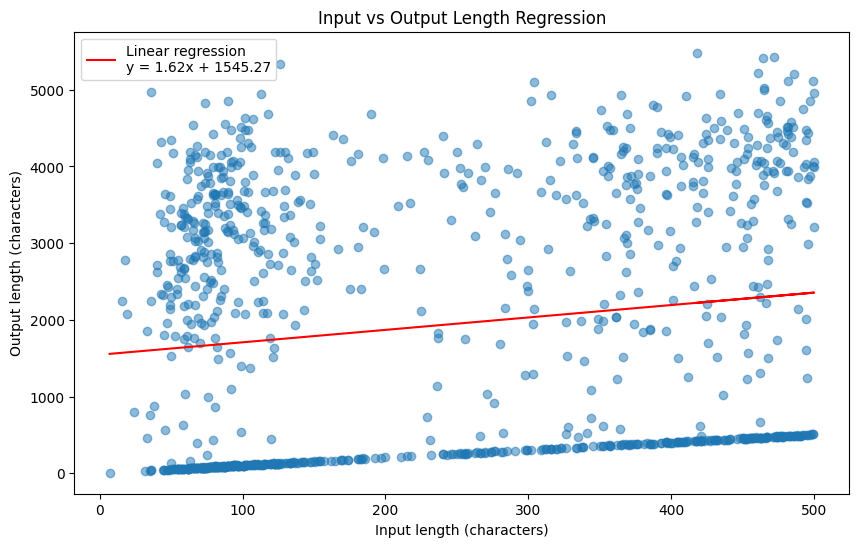

In [31]:
import numpy as np
import math
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

Xy_pairs = np.stack([lengths_input, lengths_output], axis=1)
assert Xy_pairs.shape == (len(lengths_input), 2)
# Sort Xy_pairs by output length (second column, index 1)
sorted_indices = np.argsort(Xy_pairs[:, 1])
Xy_pairs_sorted = Xy_pairs[sorted_indices]
lowest_percentile = 0.0
highest_percentile = 0.4 # correlation close to 1 and looks almost perfect here
highest_percentile = 1.0 # here you will see two classes: the unpredictable ones and the predictable ones...
Xy_pairs = Xy_pairs_sorted[
    math.floor(len(Xy_pairs)*lowest_percentile):
    math.ceil(len(Xy_pairs)*highest_percentile)
]
X, y = Xy_pairs[:, 0].reshape(-1, 1), Xy_pairs[:, 1]
# Fit linear regression
reg = LinearRegression().fit(X, y)

# Calculate correlation coefficient
correlation_coeff = np.corrcoef(X.flatten(), y)
assert correlation_coeff.shape == (2, 2)
assert np.allclose(correlation_coeff[0, 1], correlation_coeff[1, 0])
assert np.allclose(correlation_coeff[0, 0], 1.0)
assert np.allclose(correlation_coeff[1, 1], 1.0)
correlation_coeff = correlation_coeff[0, 1]


print("lowest_percentile", lowest_percentile)
print("highest_percentile", highest_percentile)
print(f"R² score: {reg.score(X, y):.3f}")
print(f"Slope: {reg.coef_[0]:.3f}")
print(f"Intercept: {reg.intercept_:.3f}")
print(f"Correlation coefficient: {correlation_coeff:.3f}")

# Plot regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5)
plt.plot(X, reg.predict(X), color='red', label=f'Linear regression\ny = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f}')
plt.xlabel('Input length (characters)')
plt.ylabel('Output length (characters)')
plt.title('Input vs Output Length Regression')
plt.legend()
plt.show()


In [32]:
"""
We observe that in either case for each dataset, there is basically a linear relationship between input and output EXCEPT
for maybe around half the dataset... so around half the dataset is fully predictable and the other half is not predictable.

That means that the estimator should be far better than `0.155` (it is) to be good, but beyond that, we should
ideally observe that this is really close to random (looking) if we plot the length relationships or other
known features.
"""

'\nWe observe that in either case for each dataset, there is basically a linear relationship between input and output EXCEPT\nfor maybe around half the dataset... so around half the dataset is fully predictable and the other half is not predictable.\n\nThat means that the estimator should be far better than `0.155` (it is) to be good, but beyond that, we should\nideally observe that this is really close to random (looking) if we plot the length relationships or other\nknown features.Z\n'